# Getting Started With Geospatial Data Analysis

[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/samx18/geospatial_analysis/blob/main/geospatial_analysis.ipynb)

This notebook is part of the blog post [Getting Started with Geospatial Analysis on SageMaker Studio Lab](https://towardsdatascience.com/getting-started-with-geospatial-analysis-b2116c50308b) and covers the basics of getting started with Geospatial Data Analysis on SageMaker Studio Labs. We start with exploring publicly available geographic datasets and then explore the sentinel geospatial dataset available at AWS open data registry. We explore California Lakes and Counties using geographic vector data and then focus Lake Shasta in California for analyzing Sentinel-2 geospatial data and calculating spectral indices. 

## Install Packages (Optional)
Creating a environment in Studio Lab is easy, just select the environment.yml file (by cloning this repository or upload it directly), right click the YAML file and select create environment. Once the environment is created, you should open this notbook with the newly created kernel. Optionally you can also uncomment the package installation section of the notebook to install these packages manually. 

In [19]:
print('this works')

this works


In [1]:
# %pip install pandas
# %pip install numpy
# %pip install geopandas
# %pip install shapely
# %pip install matplotlib
# %pip install plotly_express
# %pip install sentinelhub
# %pip install rasterio
# %pip install earthpy

## Import Packages
After the environment is created and selected or the packages installed manually, we can import them directly.

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import plotly_express as px
import os
import warnings
warnings.filterwarnings('ignore')

## Download Data
Download shapely files that include the geographic data for California counties and water bodies. 
- The CA Counties dataset contains boundaries for CA State, counties and places from the US Census Bureau's 2016 MAF/TIGER database available at https://data.ca.gov/dataset/ca-geographic-boundaries . 
- The California water bodies dataset is published by California. Department of Fish and Game. Marine Resources Region and is available for download here - https://maps.princeton.edu/download/file/stanford-zx543xm6802-shapefile.zip 

After the files are downloaded, we need to unzip these in your local directories.


In [3]:
# Download and extract California counties dataset

ca_base_url = 'https://data.ca.gov/dataset/e212e397-1277-4df3-8c22-40721b095f33/resource/b0007416-a325-4777-9295-368ea6b710e6/download/'
ca_data_file = 'ca-county-boundaries.zip'

if not os.path.isfile(ca_data_file):
    !wget {ca_base_url}{ca_data_file}
    !unzip -o {ca_data_file}

# Download and extract California lakes dataset

lakes_base_url = 'https://maps.princeton.edu/download/file/'
lakes_data_file = 'stanford-zx543xm6802-shapefile.zip'
if not os.path.isfile(lakes_data_file):
    !wget {lakes_base_url}{lakes_data_file}
    !unzip -o {lakes_data_file} -d ca_lakes

## Geographic EDA
Once downloaded, we can read the data and perform exploratory data analysis. We use the `geopanads` python package that makes it easy to read these shapefiles and create a `geopandas.DataFrame`.

In [4]:
file = 'CA_Counties/CA_Counties_TIGER2016.shp'
counties = gpd.read_file(file)
counties.shape

(58, 18)

In [5]:
# data check
counties.head()

STATEFP COUNTYFP  COUNTYNS  GEOID           NAME              NAMELSAD LSAD  \
0      06      091  00277310  06091         Sierra         Sierra County   06   
1      06      067  00277298  06067     Sacramento     Sacramento County   06   
2      06      083  00277306  06083  Santa Barbara  Santa Barbara County   06   
3      06      009  01675885  06009      Calaveras      Calaveras County   06   
4      06      111  00277320  06111        Ventura        Ventura County   06   

  CLASSFP  MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND      AWATER  \
0      H1  G4020  None   None     None        A  2468694587    23299110   
1      H1  G4020   472  40900     None        A  2499183617    76073827   
2      H1  G4020  None  42200     None        A  7084000598  2729814515   
3      H1  G4020  None   None     None        A  2641820834    43806026   
4      H1  G4020   348  37100     None        A  4773390489   945942791   

      INTPTLAT      INTPTLON  \
0  +39.5769252  -120.5219926   
1  +38.4500114  -121.3404409   
2  +34.5370572  -120.0399729   
3  +38.1838996  -120.5614415   
4  +34.3587415  -119.1331432   

                                            geometry  
0  POLYGON ((-13431319.751 4821511.426, -13431312...  
1  POLYGON ((-13490651.476 4680831.603, -13490511...  
2  MULTIPOLYGON (((-13423116.772 4042044.149, -13...  
3  POLYGON ((-13428575.483 4627725.228, -13428534...  
4  MULTIPOLYGON (((-13317853.594 3931602.414, -13...

Once you have the data in a `geopandas.DataFrame` you can easily visualize it. Like standard `pandas.DataFrames`, a `geopandas.DataFrame` has a handy plot method that you can use to create geographic visualizations.

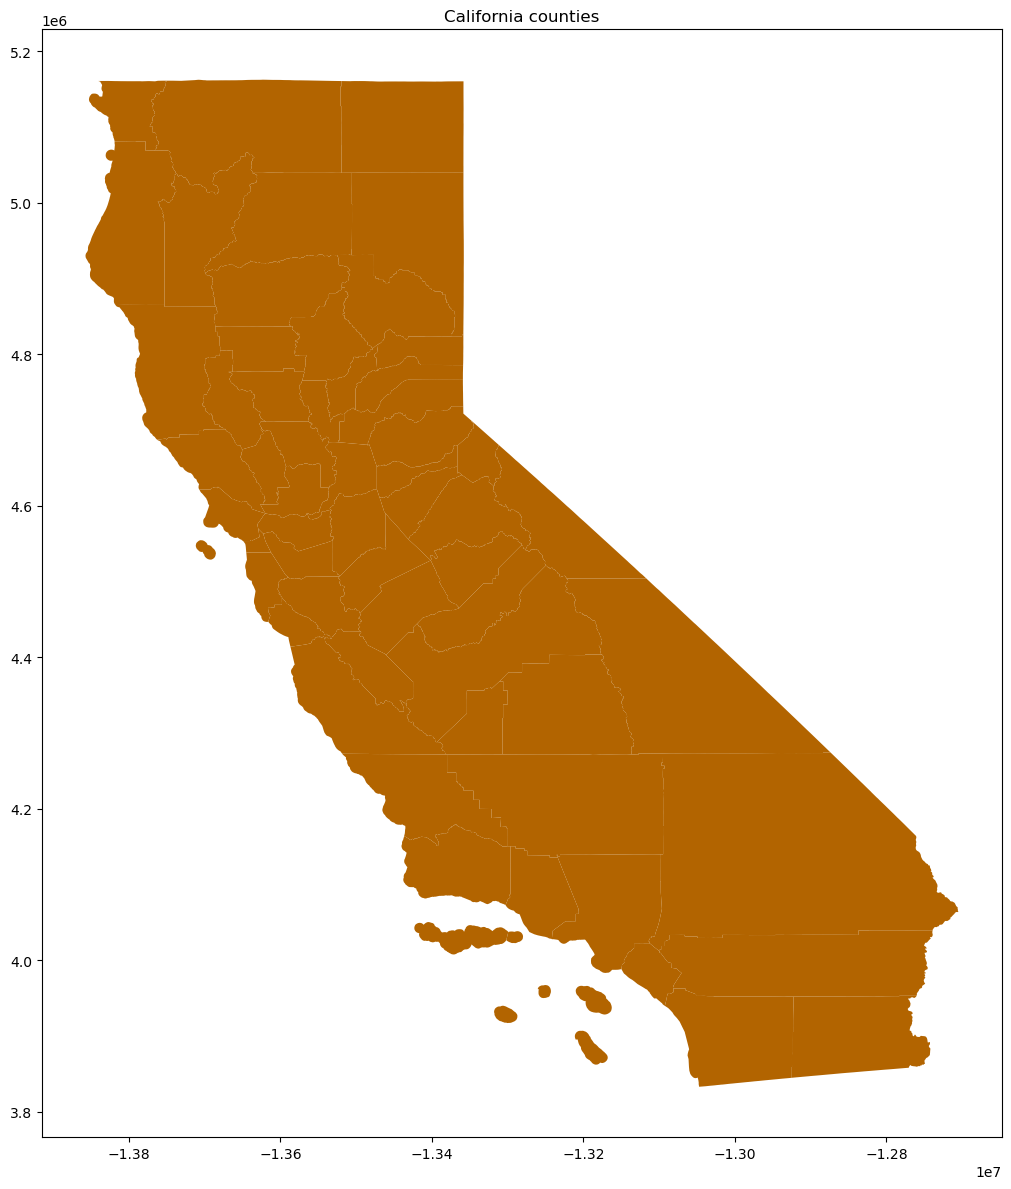

In [6]:
fig, ax = plt.subplots(figsize=(12,12))
counties.plot(ax=ax,color='xkcd:umber')
plt.title("California counties")
plt.tight_layout()
plt.show()

Similarly we will read the California lakes shapefile into a `geopandas.DataFrame` and visualize it

In [7]:
file = 'ca_lakes/zx543xm6802.shp'
lakes = gpd.read_file(file)
lakes.shape #check shape

(27506, 17)

In [8]:
# data profile
lakes.head()

dfgwaterid       type         name    gnis_name    gnis_id     county  \
0           2       None         None         None        0.0   Siskiyou   
1           5  perennial  Azalea Lake  Azalea Lake   256390.0   Siskiyou   
2           9       None   White Lake   White Lake   269006.0   Siskiyou   
3          35       None  Bear Wallow  Bear Wallow   256730.0  Del Norte   
4          39       None     Mud Lake     Mud Lake  1657412.0   Siskiyou   

            quad_name quad_code  lat_nad83   lon_nad83  utm_zone  \
0     COTTONWOOD PEAK   41122H6  41.995514 -122.634687      10.0   
1     FIGUREHEAD MTN.   41123H3  41.969883 -123.300531      10.0   
2  LOWER KLAMATH LAKE   41121H6  41.994778 -121.633244      10.0   
3     BROKEN RIB MTN.   41123H6  41.950329 -123.654790      10.0   
4              DORRIS   41121H8  41.985547 -121.983720      10.0   

      utm_n_n83      utm_e_n83        mtr  elev_ft   sfc_acres  \
0  4.649343e+06  530256.529651  M48N  07W     2832   12.647377   
1  4.646476e+06  475099.025138  H18N  08E     5383    4.601394   
2  4.650100e+06  613201.864414  M48N  03E     4093  814.471819   
3  4.644469e+06  445729.565005  H18N  05E     4380    0.292219   
4  4.648671e+06  584185.392854  M48N  01W     4763   11.463147   

                                            geometry  
0  POLYGON Z ((-122.63289 41.99307 0.00000, -122....  
1  POLYGON Z ((-123.30003 41.96928 0.00000, -123....  
2  MULTIPOLYGON Z (((-121.64562 41.99941 0.00000,...  
3  POLYGON Z ((-123.65462 41.95016 0.00000, -123....  
4  POLYGON Z ((-121.98280 41.98446 0.00000, -121....

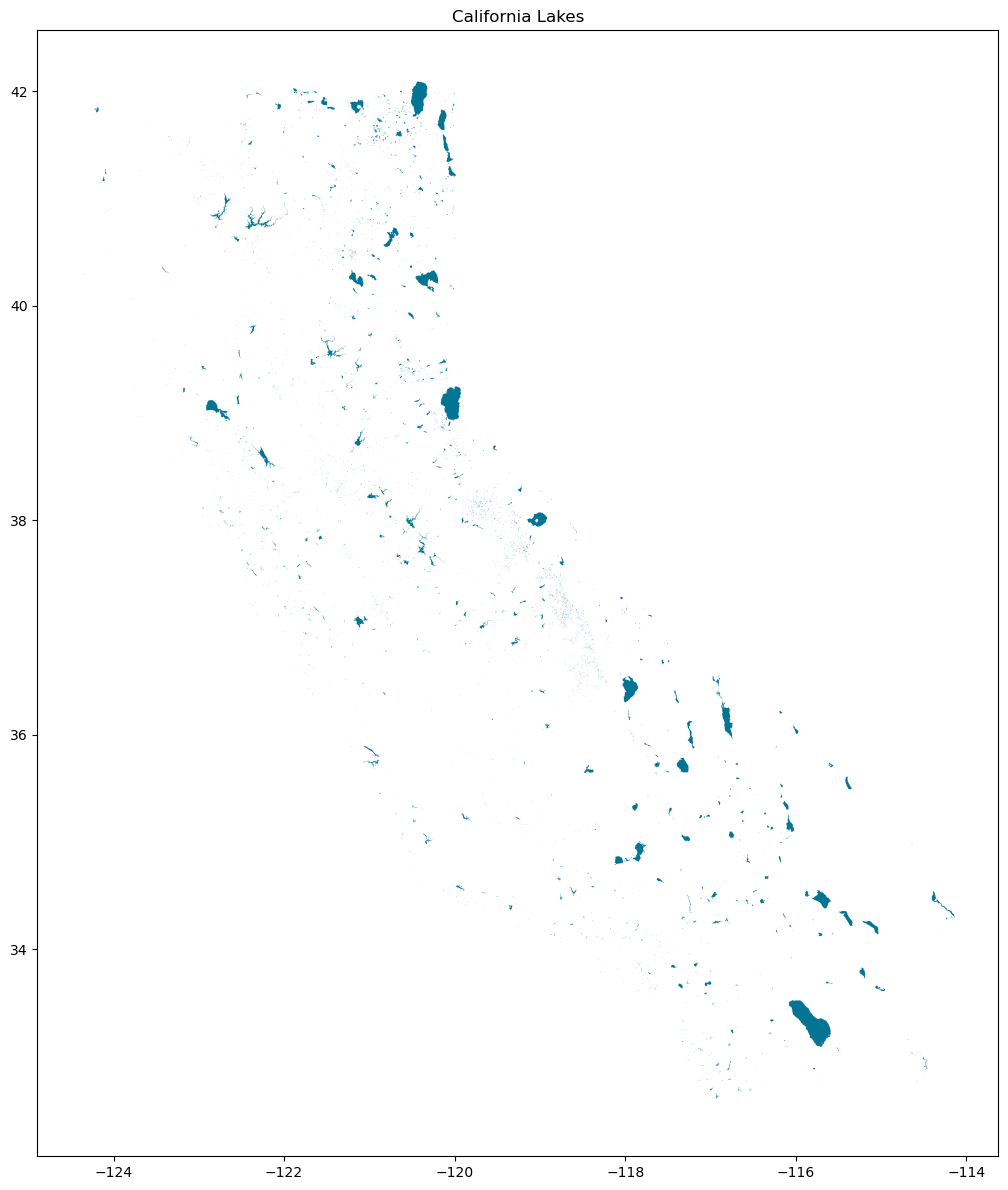

In [9]:
fig, ax = plt.subplots(figsize=(12,12))
lakes.plot(ax=ax, color='xkcd:sea blue')
plt.title("California Lakes")
plt.tight_layout()
plt.show()

## Data Wrangling
Let's say we want to overlay the lakes data with the counties data and visualize the lakes along with California counties. Before we can do that,  we need to check and ensure they are projected using the same coordinate reference system (CRS). The `crs` attribute of a `geopanads.DataFrame` does exactly this.  

In [10]:
counties.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
lakes.crs

<Geographic 2D CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In our case the California counties and lakes data have different CRS.  So we will re-project the lakes to have the same CRS as counties.

In [12]:
# re-project lakes to epsg:3857
lakes_projected = lakes.to_crs({'init': 'epsg:3857'})

Once we have both the geographic datasets in the same CRS projection, we can overlay and visualize them. 

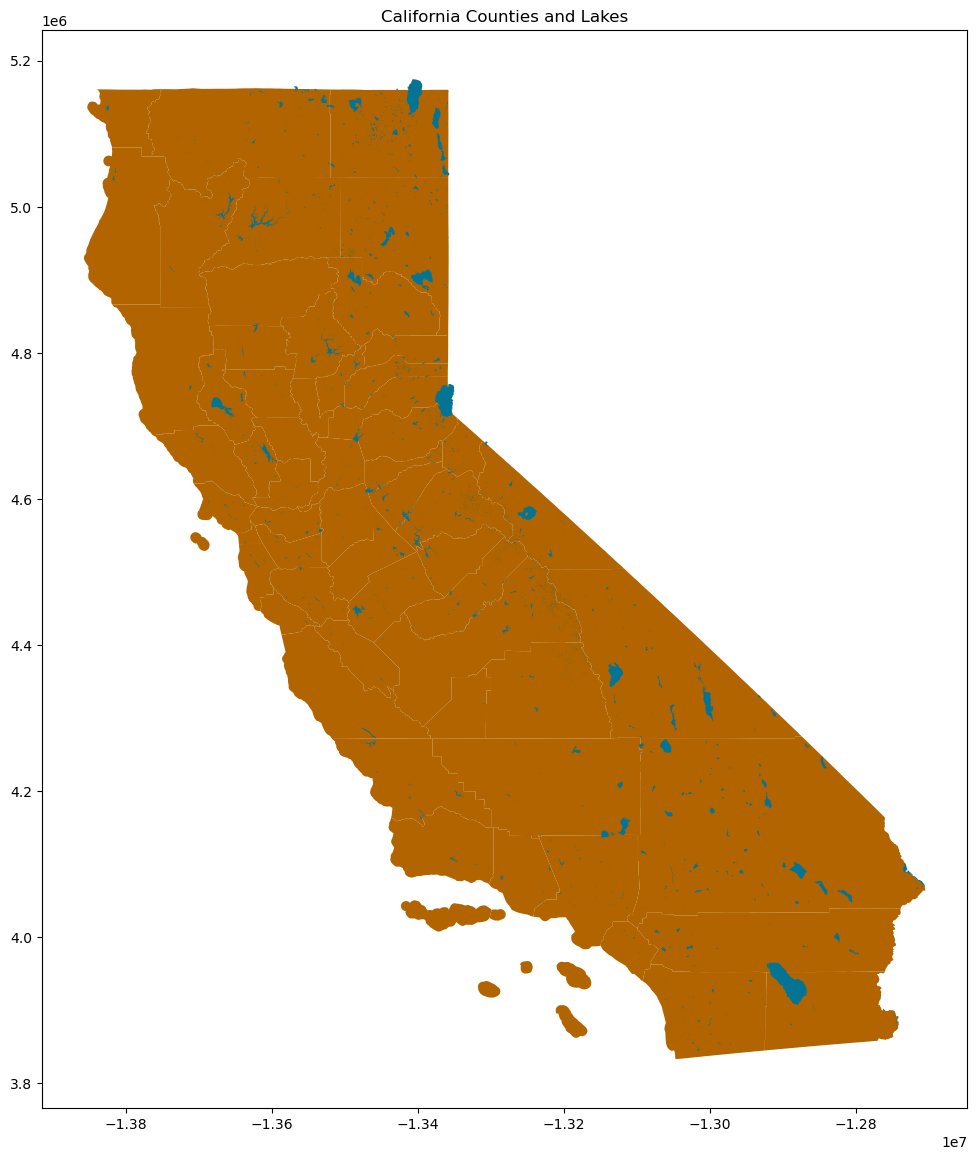

In [13]:
# visualize overlay
fig, ax = plt.subplots(figsize=(14,14))
counties.plot(ax=ax,color='xkcd:umber')
lakes_projected.plot(markersize=1, color='xkcd:sea blue',ax=ax)
plt.title("California Counties and Lakes")
plt.show()

#### Subset Selection
We can select a subset of data from the our `geopandas.DataFrame` to create a new `geopandas.DataFrame` for further analysis and visualization. For our example, let's focus on Lake Shasta. 

In [14]:
shasta = lakes_projected[lakes_projected['name'] == "Lake Shasta"]
shasta.head()

dfgwaterid       type         name    gnis_name   gnis_id  county  \
1218         784  perennial  Lake Shasta  Shasta Lake  253897.0  Shasta   

     quad_name quad_code  lat_nad83   lon_nad83  utm_zone    utm_n_n83  \
1218   O'BRIEN   40122G3  40.765934 -122.298688      10.0  4513010.636   

        utm_e_n83        mtr  elev_ft     sfc_acres  \
1218  559189.7561  M34N  04W     1069  28355.438839   

                                               geometry  
1218  MULTIPOLYGON Z (((-13618707.923 4990067.530 0....

#### Plotting Selection
Once we have our area of interest selected, it becomes easy to visualize and study it better.

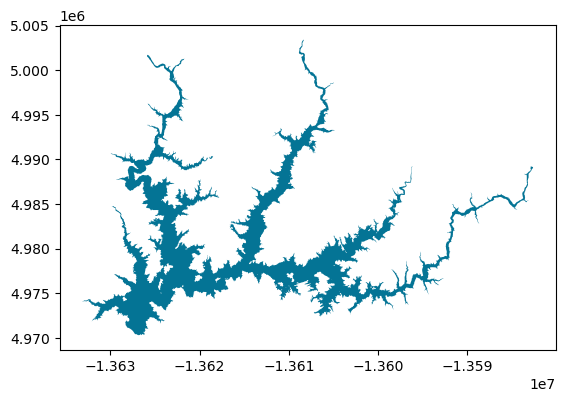

In [15]:
shasta.plot(color='xkcd:sea blue');

## Working With Geospatial Images
For Geospatial data, we will use Sentinel-2. The [Sentinel-2 mission](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) is a land monitoring constellation of two satellites that provide high resolution optical imagery and continuity for the current SPOT and Landsat missions. The Sentinel-2 dataset is available publicly at the [AWS open data registry](https://registry.opendata.aws/sentinel-2/).

We will use the `sentinelhub` python package, that makes it easy to search and download data specific to our focus area directly from AWS. 

In [18]:
from sentinelhub import SHConfig
config = SHConfig()

#### Sentinel Hub Setup
This section shows how to configure your credentials for sentinelhub. We are using a optional json file to store and retrieve credentials.

In [17]:
import json

with open("config.json") as json_data_file:
    cfg = json.load(json_data_file)

FileNotFoundError: [Errno 2] No such file or directory: 'config.json'

In [18]:
# instance_id - Instance ID from from your Sentinel Hub account 
# aws_access_key_id - Access key ID from your AWS account
# aws_secret_access_key - Secrect access key from your AWS account

config.instance_id = cfg["sentinelhub"]["instance_id"]
config.aws_access_key_id = cfg["aws"]["access_key_id"]
config.aws_secret_access_key = cfg["aws"]["secret_access_key"]

In [19]:
# Save the configuration
config.save()

In [20]:
# Verify credentials

from sentinelhub import WebFeatureService, BBox, CRS, DataCollection, SHConfig
if config.instance_id == '':
    print("Warning! To use WFS functionality, please configure the `instance_id`.")

#### Data Search
Before we download, we need to specify our search coordinates that we want to study and the time window. In our case we are focusing on the Lake Shasta region, which we specify as a bounding box and a random time period.

In [21]:
# Specify bounding box and time interval for search

search_bbox = BBox(bbox=[-123.050516,37.845040,-122.523172,38.249508], crs=CRS.WGS84)

search_time_interval = ('2019-08-01T00:00:00', '2019-08-15T23:59:59')


wfs_iterator = WebFeatureService(
    search_bbox,
    search_time_interval,
    data_collection=DataCollection.SENTINEL2_L1C,
    maxcc=1.0,
    config=config
)

for tile_info in wfs_iterator:
    print(tile_info)

{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}, 'coordinates': [[[[-123.49596888938702, 37.94653523329623], [-123.77992687706502, 36.95532883423918], [-122.89037933316587, 36.95783951164065], [-122.88892538948096, 37.947528129469475], [-123.49596888938702, 37.94653523329623]]]]}, 'properties': {'id': 'S2B_OPER_MSI_L1C_TL_SGS__20190813T204954_A012723_T10SDG_N02.08', 'date': '2019-08-13', 'time': '19:04:19', 'path': 's3://sentinel-s2-l1c/tiles/10/S/DG/2019/8/13/0', 'crs': 'EPSG:32610', 'mbr': '399960,4090200 509760,4200000', 'cloudCoverPercentage': 0}}
{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}, 'coordinates': [[[[-123.00021625365561, 37.94758055791956], [-123.00021342293302, 36.95789010852225], [-121.76700583572769, 36.9514885996532], [-121.75065723902449, 37.940947339443376], [-123.00021625365561, 37.94758055

In [22]:
# List available tiles
wfs_iterator.get_tiles()

[('10SDG', '2019-8-13', 0),
 ('10SEG', '2019-8-13', 0),
 ('10SDH', '2019-8-13', 0),
 ('10SEH', '2019-8-13', 0),
 ('10SDG', '2019-8-11', 0),
 ('10SEG', '2019-8-11', 0),
 ('10SDH', '2019-8-11', 0),
 ('10SEH', '2019-8-11', 0),
 ('10SDG', '2019-8-8', 0),
 ('10SEG', '2019-8-8', 0),
 ('10SDH', '2019-8-8', 0),
 ('10SEH', '2019-8-8', 0),
 ('10SDG', '2019-8-6', 0),
 ('10SEG', '2019-8-6', 0),
 ('10SDH', '2019-8-6', 0),
 ('10SEH', '2019-8-6', 0),
 ('10SDG', '2019-8-3', 0),
 ('10SEG', '2019-8-3', 0),
 ('10SDH', '2019-8-3', 0),
 ('10SEH', '2019-8-3', 0),
 ('10SDG', '2019-8-1', 0),
 ('10SEG', '2019-8-1', 0),
 ('10SDH', '2019-8-1', 0),
 ('10SEH', '2019-8-1', 0)]

#### Picking Tiles
For best results, we pick a tile with least cloud coverage.

In [23]:
from sentinelhub import AwsTile

tile_id = 'S2A_OPER_MSI_L1C_TL_VGS2_20200815T224802_A026894_T10TEL_N02.09'
tile_name, time, aws_index = AwsTile.tile_id_to_tile(tile_id)
tile_name, time, aws_index

('10TEL', '2020-8-15', 0)

#### Sentinel Data Download
The Sentinel-2 satellites each carry a single multi-spectral instrument (MSI) with 13 spectral channels in the visible/near infrared (VNIR) and short wave infrared spectral range (SWIR). You can read more about these bands [here](https://en.wikipedia.org/wiki/Sentinel-2#Spectral_bands). For our example will download eight specific bands that will aid our analysis.

In [24]:
warnings.simplefilter("ignore", UserWarning)
from sentinelhub import AwsTileRequest

bands = ['B01','B02','B03','B04','B07','B08','B8A', 'B10','B11','B12']
metafiles = ['tileInfo', 'preview', 'qi/MSK_CLOUDS_B00']
data_folder = './AwsData'

request = AwsTileRequest(
    tile=tile_name,
    time=time,
    aws_index=aws_index,
    bands=bands,
    metafiles=metafiles,
    data_folder=data_folder,
    data_collection=DataCollection.SENTINEL2_L1C
)

request.save_data()

In [25]:
#Parse the request response 

data_list = request.get_data(redownload=True)

p_b01,p_b02,p_b03,p_b04,p_b07,p_b08,p_b8a,p_b10,p_b11,p_b12,p_tile_info, p_preview, p_cloud_mask = data_list

#### Visualize Raw Data
Along with the spectral bands, Sentinel tiles also include a preview image, let's check that out first to make sure we have the area of interest captured clearly.

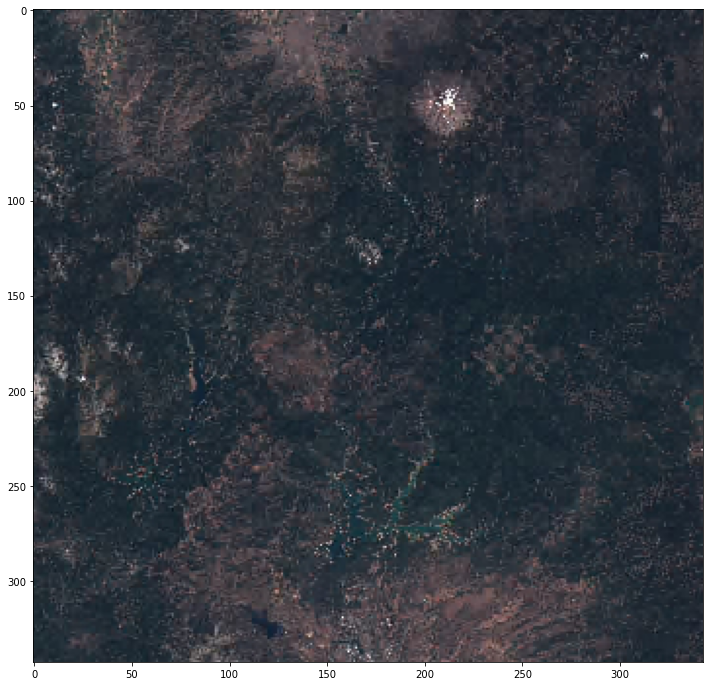

In [26]:
# Preview 

plt.figure(figsize = (12,12))
plt.imshow(p_preview,aspect='auto');

#### Checking Bands
It's also a good practice to spot check a few additional bands to make sure we have everything. Here we plot Band 7 – Vegetation red edge, Band 8 – NIR and Band 8A – Narrow NIR.

<Figure size 2592x864 with 0 Axes>

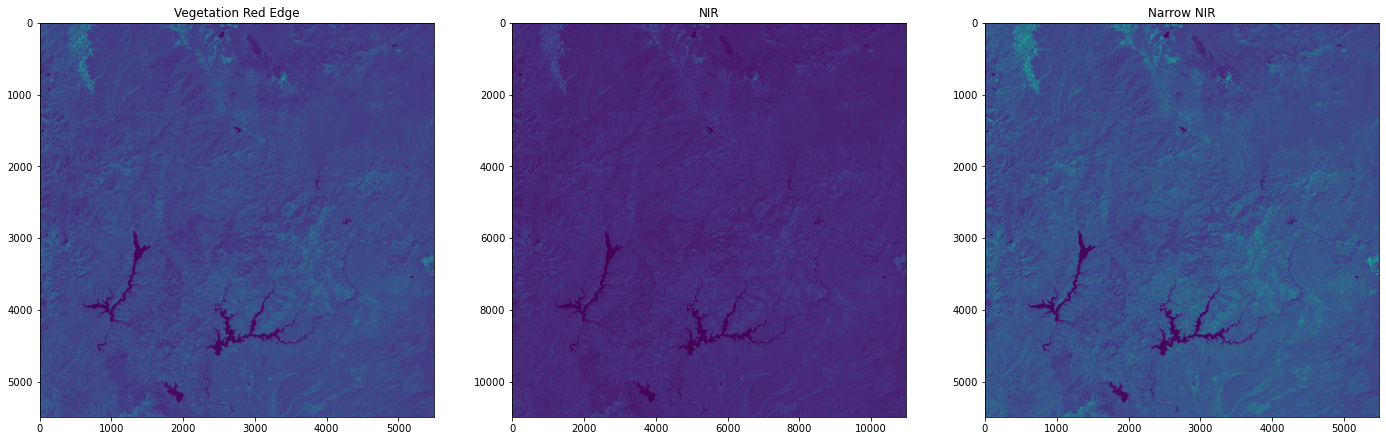

In [27]:
plt.figure(figsize = (36,12));
f, axarr = plt.subplots(1,3,figsize = (24,12));
axarr[0].imshow(p_b07);
axarr[0].title.set_text("Vegetation Red Edge")
axarr[1].imshow(p_b08);
axarr[1].title.set_text("NIR")
axarr[2].imshow(p_b8a);
axarr[2].title.set_text("Narrow NIR")

## Working with Raster Data
Geospatial data is essentially comprised of raster data or vector data. Sentinel-2 uses GeoTIFF, a gridded raster datasets for satellite imagery and terrain models. Rasterio is a Python library that allows to read, inspect, visualize and write geospatial raster data. Here we use `rasterio` to read thee raster arrays and then use this data to create a true color image.

In [28]:
import rasterio
from rasterio import plot

For getting to the true color images, we will need the blue, green, red and NIR bands.

In [29]:
# Reeading the required bands with rasterio

band2 = rasterio.open('./AwsData/10TEL,2020-08-15,0/B02.jp2', driver='JP2OpenJPEG') #blue
band3 = rasterio.open('./AwsData/10TEL,2020-08-15,0/B03.jp2', driver='JP2OpenJPEG') #green
band4 = rasterio.open('./AwsData/10TEL,2020-08-15,0/B04.jp2', driver='JP2OpenJPEG') #red
band8 = rasterio.open('./AwsData/10TEL,2020-08-15,0/B08.jp2', driver='JP2OpenJPEG') #nir

#### True Color Image
We can use `rasterio` to create a true color image in `.tiff` format. A true color image has a large file size, please ensure you have at least 2+ GBs of free disk space before exporting.

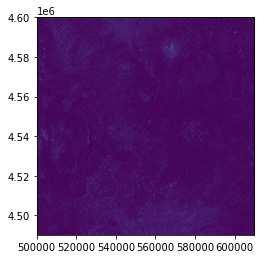

In [30]:
#export true color image
trueColor = rasterio.open('./AwsData/lake_shasta.tiff','w',driver='Gtiff',
                         width=band4.width, height=band4.height,
                         count=3,
                         crs=band4.crs,
                         transform=band4.transform,
                         dtype=band4.dtypes[0]
                         )
trueColor.write(band2.read(1),3) #blue
trueColor.write(band3.read(1),2) #green
trueColor.write(band4.read(1),1) #red
trueColor.close()

src = rasterio.open(r"./AwsData/lake_shasta.tiff", count=3)
plot.show(src);

#### Rendering a True Color Image
As you see visualizing a tiff image directly within Jupyter is not very helpful. You will need a GIS software to open and view this. Below in a example that was processed using [QGIS](https://qgis.org/)

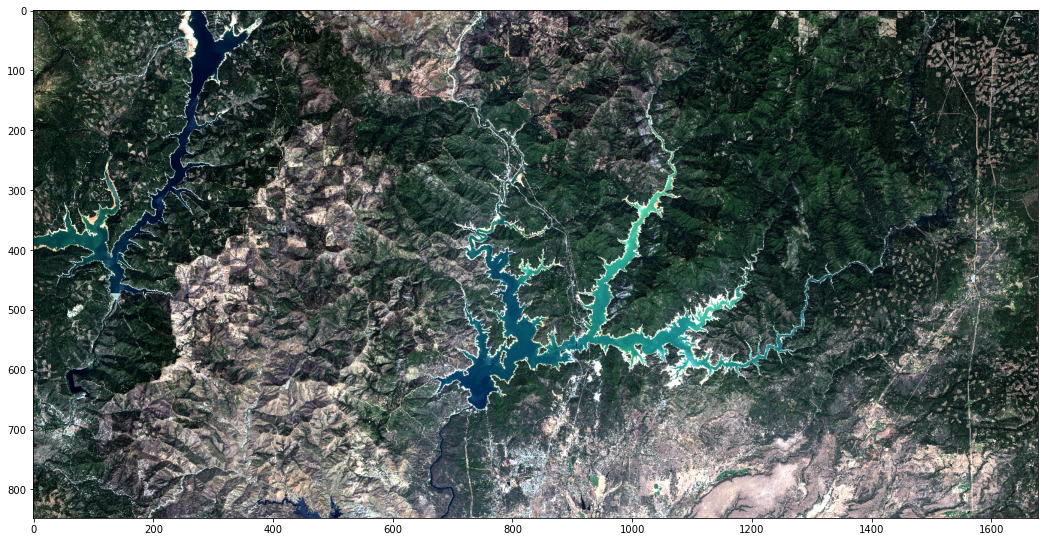

In [31]:
import matplotlib.image as mpimg
plt.figure(figsize = (18,18))
img = mpimg.imread('./images/lake_shasta.png')
imgplot = plt.imshow(img)
plt.show()

## Calculating Spectral Indices
Spectral indices are combinations of the pixel values from two or more spectral bands in a multispectral image. Spectral indices highlight pixels showing the relative abundance or lack of a land-cover type of interest in an image. Let's looks at a couple 

#### Normalized Difference Vegetation Index - NVDI
The normalized difference vegetation index is a simple graphical indicator that can be used to analyze whether or not the target being observed contains live green vegetation. 

It calculated as `NDVI = (NIR – Red) / (NIR + Red)`

In [32]:
b4 = rasterio.open('./AwsData/10TEL,2020-08-15,0/B04.jp2')
b8 = rasterio.open('./AwsData/10TEL,2020-08-15,0/B08.jp2')

# read Red(b4) and NIR(b8) as arrays
red = b4.read()
nir = b8.read()
ndvi = (nir.astype(float)-red.astype(float))/(nir.astype(float)+red.astype(float))

The `earthpy` package allows easy plotting of visualization of bands, we use it here to visualize the Normalized Difference Vegetation index around the Lake Shasta region.

In [33]:
import earthpy.spatial as es
import earthpy.plot as ep

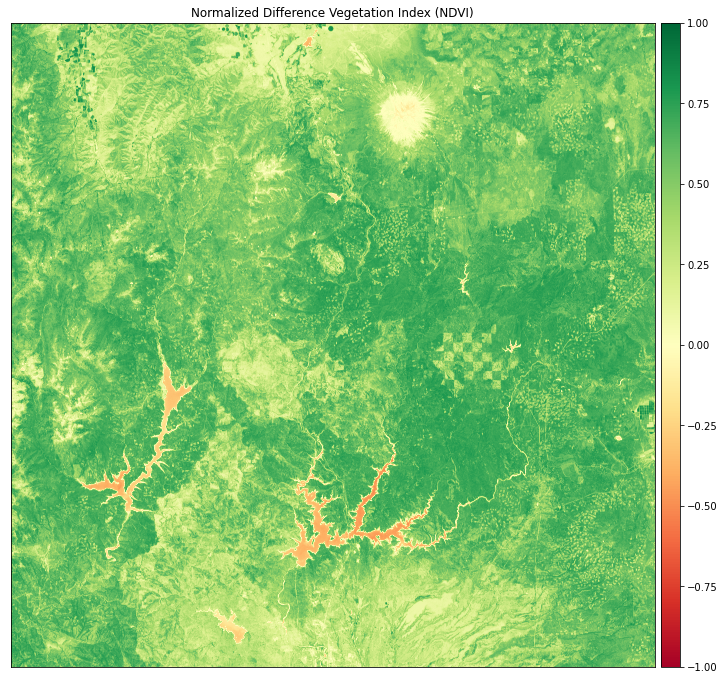

In [34]:
title = "Normalized Difference Vegetation Index (NDVI)"
ep.plot_bands(ndvi, cmap="RdYlGn", cols=1, title=title, vmin=-1, vmax=1);

You can see areas with vegetation in green, areas with dense vegetation as darker shades of green, water bodes generally have low to no vegetation and as such in a contrasting shade of orange. 

#### Normalized Difference Water Index - NDWI
Normalized Difference Water Index (NDWI) is use for analyzing water bodies. The index uses Green and Near infra-red bands of remote sensing images. The NDWI can enhance water information efficiently in most cases.

NDWI is calculated as `NDWI = (GREEEN – NIR) / (GREEN + NIR)`

In [35]:
b3 = rasterio.open('./AwsData/10TEL,2020-08-15,0/B03.jp2')
b8 = rasterio.open('./AwsData/10TEL,2020-08-15,0/B08.jp2')
# read Gree(b4) annd NIR(b8) as arrays
green = b3.read()
nir = b8.read()
ndwi = (green.astype(float)-nir.astype(float))/(green.astype(float)+nir.astype(float))

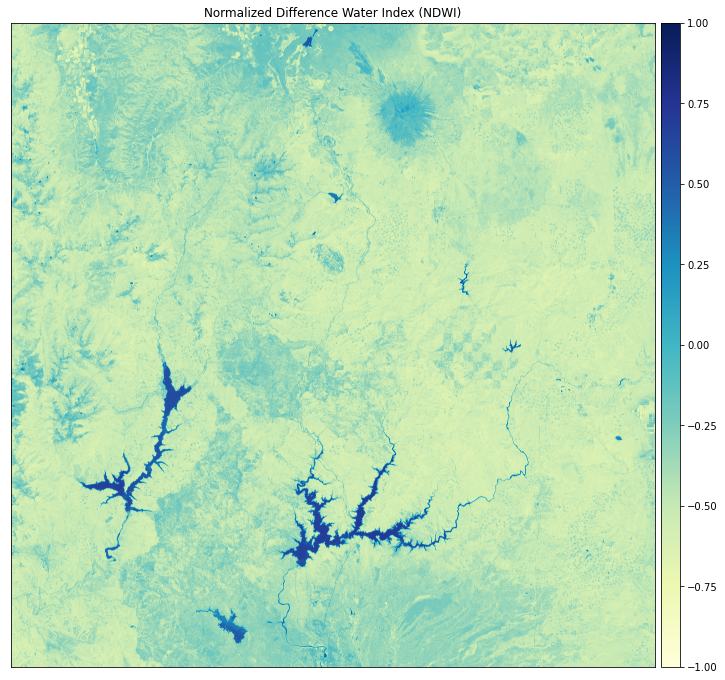

In [36]:
title = "Normalized Difference Water Index (NDWI)"
ep.plot_bands(ndwi, cmap='YlGnBu', cols=1, title=title, vmin=-1, vmax=1); #cmap='YlGnBu'

The above visualization shows us the values plotted for the Lake Shasta region. You can see the lake area in blue and the areas with no or less water in contrasting shades.

## Clean Up (Optional)
Though we did not create any AWS billable resources as part of this exercise, the geographic and GIS data that we downloaded and the images generated may take up significant storage. Make sure to check any storage utilization and delete the files as needed.